<a href="https://colab.research.google.com/github/gilad-altshuler/Three_Body_RNN/blob/main/notebooks/4_MultiFate_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import sys, os
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Colab. Cloning repo...")
    !git clone https://github.com/gilad-altshuler/Three_Body_RNN.git
    %cd Three_Body_RNN
    ROOT = Path(".").resolve()

    # Load Arial font
    !wget -O Arial.ttf "https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf"

else:
    print("Not running in Colab.")
    ROOT = Path(__file__).resolve().parent.parent
    sys.path.append(str(ROOT))

Running in Colab. Cloning repo...
Cloning into 'Three_Body_RNN'...
remote: Enumerating objects: 1235, done.
remote: Counting objects: 100% (299/299), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 1235 (delta 165), reused 177 (delta 76), pack-reused 936 (from 2)
Receiving objects: 100% (1235/1235), 478.56 MiB | 22.56 MiB/s, done.
Resolving deltas: 100% (658/658), done.
/content/Three_Body_RNN
--2025-08-28 07:36:42--  https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf [following]
--2025-08-28 07:36:43--  https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.13

In [2]:
import torch
import random
from torch import nn
import numpy as np
import copy
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
%matplotlib inline
if IN_COLAB:
  fm.fontManager.addfont('Arial.ttf')
  arial_fp = fm.FontProperties(fname='Arial.ttf')
  plt.rcParams['font.family'] = arial_fp.get_name()
else:
  plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 10
import seaborn as sns
import pickle

import methods.utils as utils
from tasks.MultiFate_task import generate_data
from methods.models import *

In [3]:
DATA_DIR = ROOT / "data" / "multifate_inference"
FIG_DIR = ROOT / "notebooks" / "figures"

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
SEED = 3150
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Uncomment to generate new multifate data

In [6]:
# N = 30 # n.o proteins
# T = 100
# data_size = 256
# params = (dt, Kd, n, alpha, beta, inducers) = (0.2,1,1.5,3.6,90.0,0)
# input, x_half = generate_data(data_size, T, N, *params)



# # that prints:


# # TFs ON: Y1, count: X1
# # TFs ON: Y2, count: X2
# # TFs ON: Y3, count: X3
# # .....


load preproccessed 15 high concentration at fixed point out of 30 TFs and zero input

In [7]:
N = 30 # n.o proteins
T = 100
data_size = 256
params = (dt, Kd, n, alpha, beta, inducers) = (0.2,1,1.5,3.6,90.0,0)
input = torch.load(DATA_DIR / "input.pth",map_location=DEVICE)
x_half = torch.load(DATA_DIR / "target.pth",map_location=DEVICE)

Dataset visualize and stats

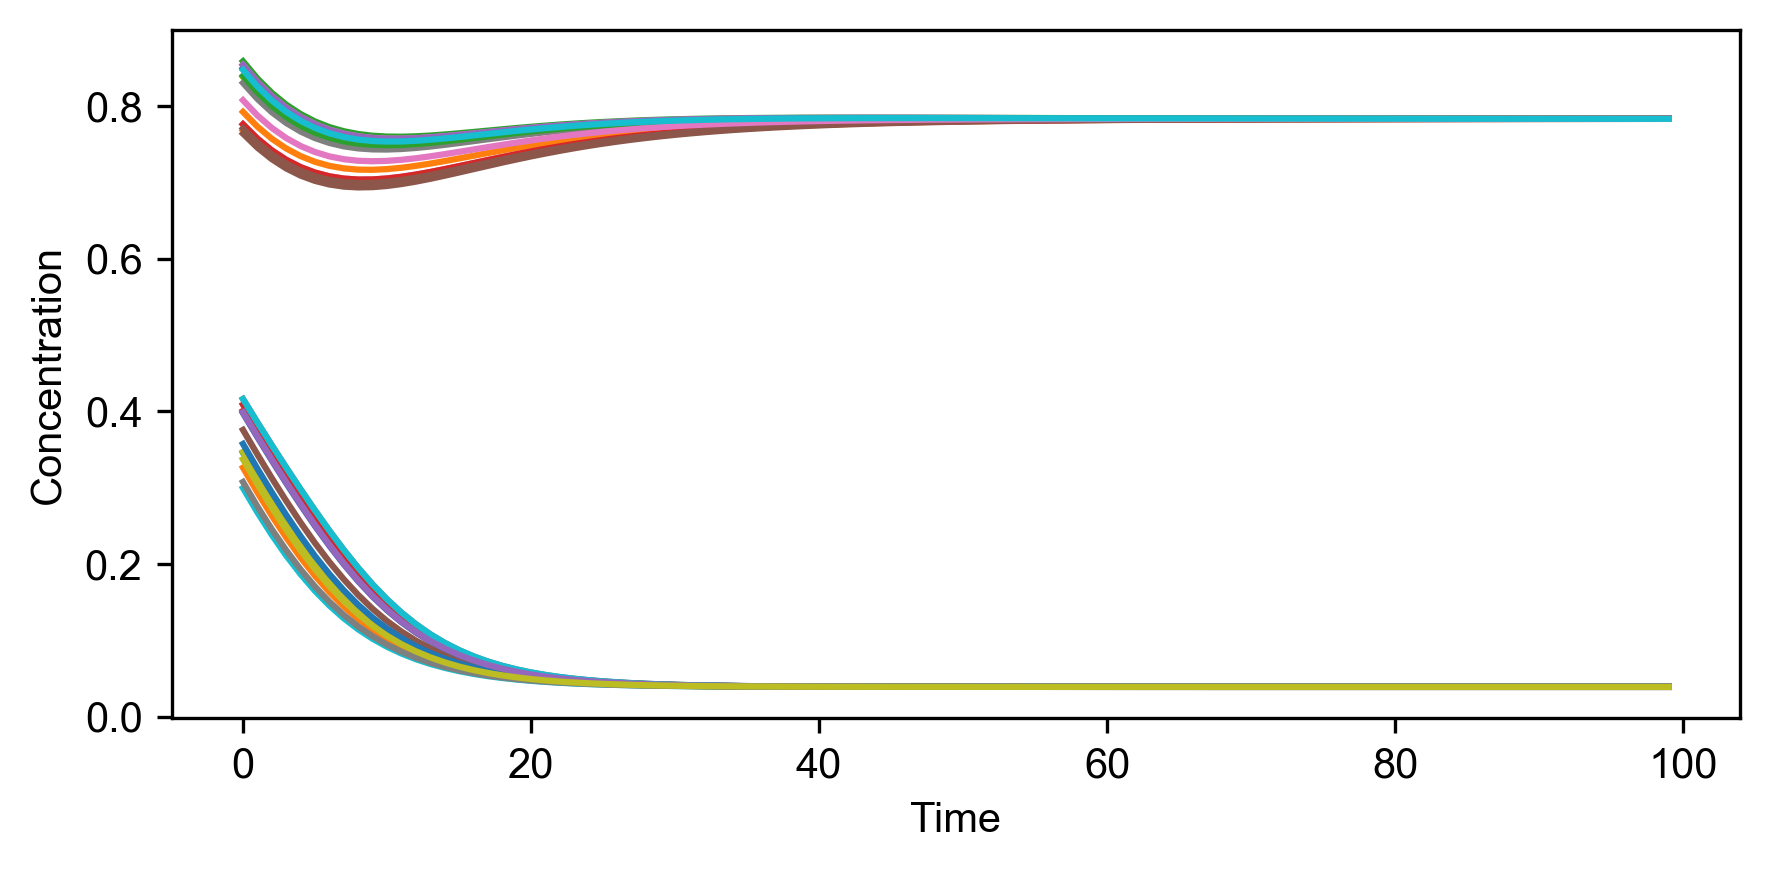

In [8]:
IDX = 2
plt.figure(figsize=(6, 3),dpi=300)
_=plt.plot(x_half[IDX].cpu().numpy())
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.tight_layout()

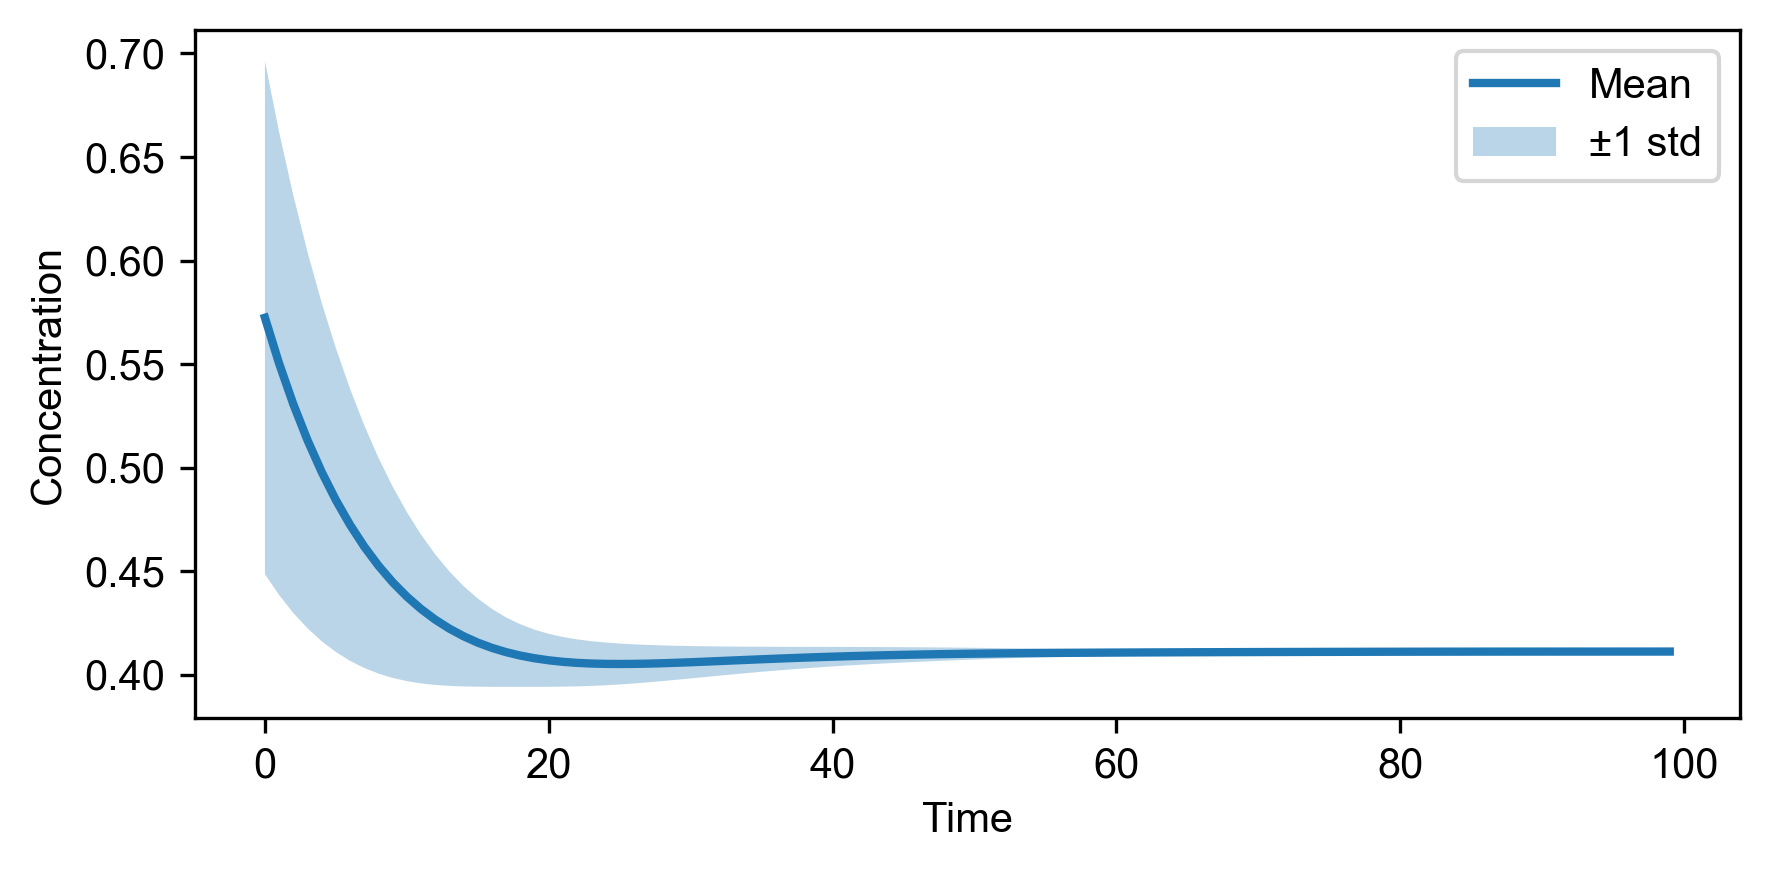

In [9]:
plt.figure(figsize=(6, 3),dpi=300)
t= np.arange(T)
mean = x_half.mean(dim=-1).mean(dim=0).cpu().numpy()
std = x_half.mean(dim=-1).std(dim=0).cpu().numpy()
plt.plot(t,mean, label='Mean', linewidth=2)
plt.fill_between(t,mean - std, mean + std, alpha=0.3, label='±1 std')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.tight_layout()

Train RNN, TBRNN, HORNN to infer MultiFate 15 upregulated TFs

In [10]:
input_size=output_size=hidden_dim=N
w_out = torch.nn.Identity()
hidden=x_half[:,0,:]

tbrnn_student = TBRNN(input_size, output_size, hidden_dim,
                      mode='cont', form='rate',nonlinearity=torch.tanh,output_nonlinearity=torch.sigmoid,task=None,noise_std=0.0,
                      tau=0.2, Win_bias=True,Wout_bias=True,w_out=w_out).to(DEVICE)
rnn_student = RNN(input_size, output_size, hidden_dim,
                      mode='cont', form='rate',nonlinearity=torch.tanh,output_nonlinearity=torch.sigmoid,task=None,noise_std=0.0,
                      tau=0.2, Win_bias=True,Wout_bias=True,w_out=w_out).to(DEVICE)
hornn_student = HORNN(input_size, output_size, hidden_dim,
                      mode='cont', form='rate',nonlinearity=torch.tanh,output_nonlinearity=torch.sigmoid,task=None,noise_std=0.0,
                      tau=0.2, Win_bias=True,Wout_bias=True,w_out=w_out).to(DEVICE)

rnn_student.load_state_dict(torch.load(DATA_DIR / "RNN_student.pth",map_location=DEVICE))
tbrnn_student.load_state_dict(torch.load(DATA_DIR / "TBRNN_student.pth",map_location=DEVICE))
hornn_student.load_state_dict(torch.load(DATA_DIR / "HORNN_student.pth",map_location=DEVICE))

<All keys matched successfully>

In [11]:
with open(DATA_DIR / "stats.pkl", "rb") as f:
    stats = pickle.load(f)
cka = stats['cka']
r2s = stats['r2']
models = ['rnn','tbrnn','hornn']
for model in models:
  print(f"{model.upper()}:")
  print(f"\tMean linear kernel CKA - {cka[model].mean():.4f}, std - {cka[model].std():.4f}")
  print(f"\tMean r2 - {r2s[model].mean():.4f}, std - {r2s[model].std():.4f}")

RNN:
	Mean linear kernel CKA - 0.6623, std - 0.0081
	Mean r2 - 0.4923, std - 0.0102
TBRNN:
	Mean linear kernel CKA - 0.8978, std - 0.0195
	Mean r2 - 0.8643, std - 0.0219
HORNN:
	Mean linear kernel CKA - 0.9284, std - 0.0116
	Mean r2 - 0.9025, std - 0.0138


visualize model - recurrent tensors

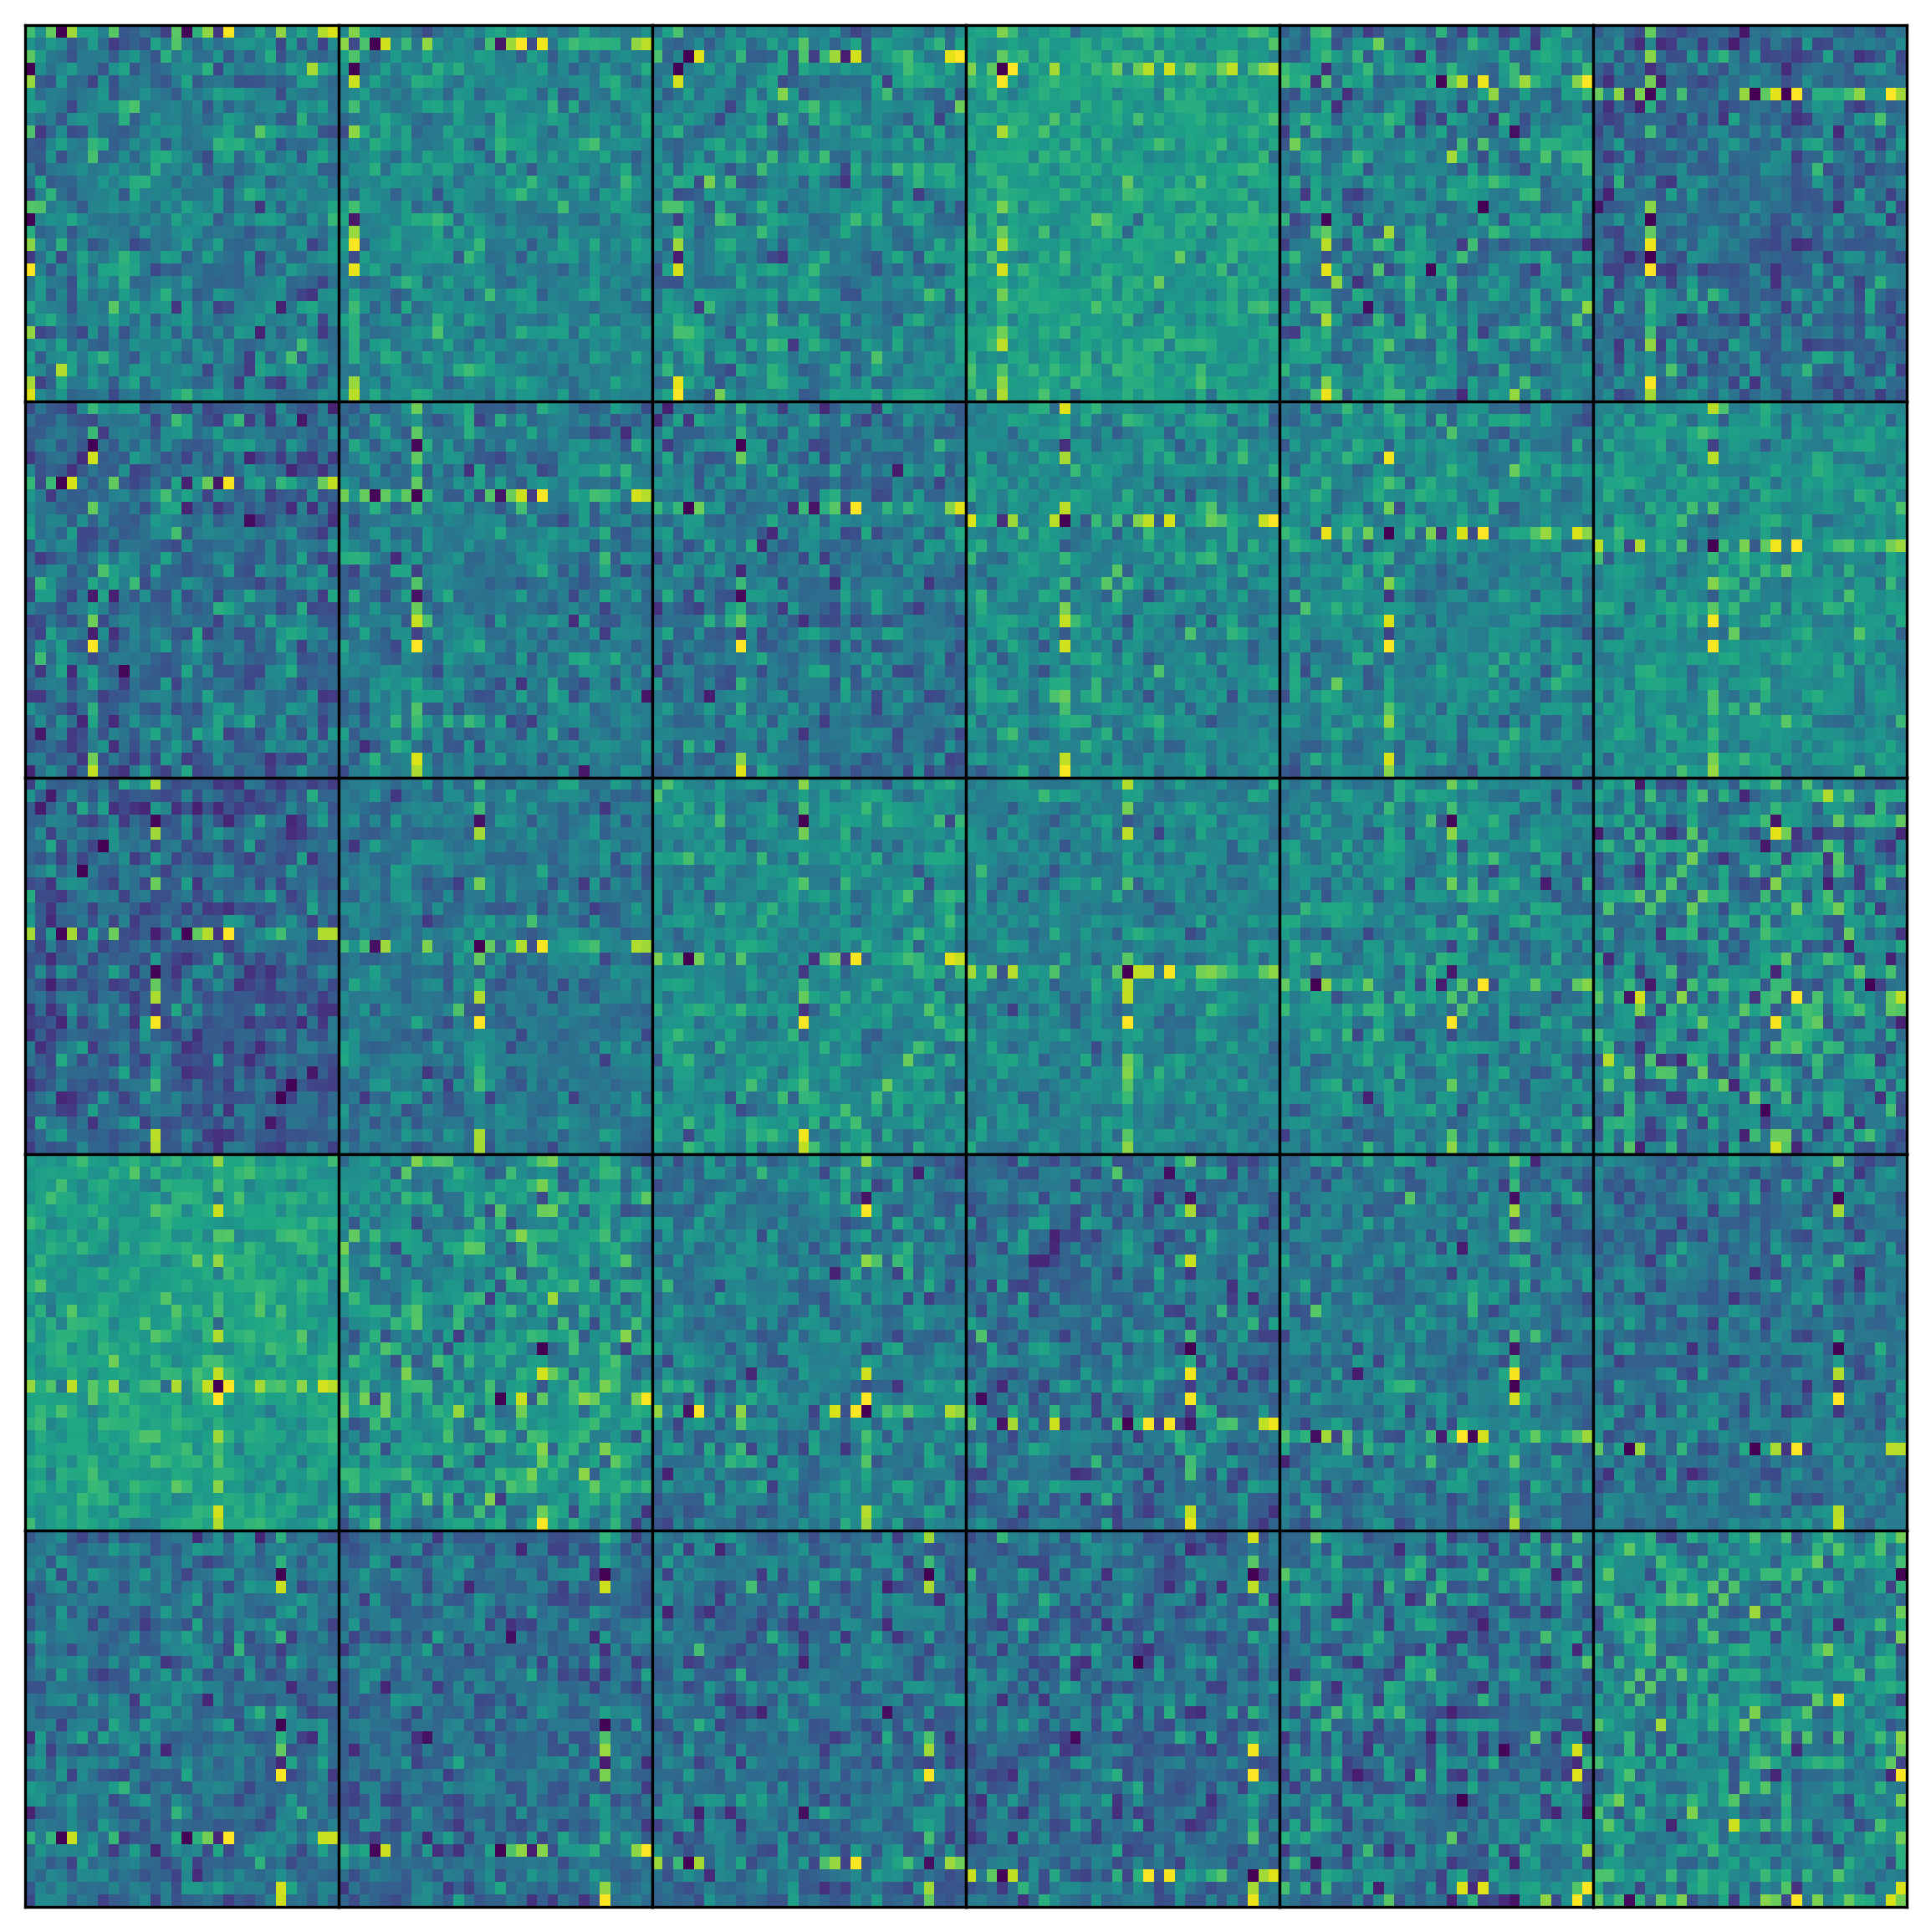

In [12]:
W = tbrnn_student.w_hh
fig = plt.figure(figsize=(7.5, 7.5),dpi=300)
for i in range(hidden_dim):
    ax = fig.add_subplot(5, 6, i + 1)
    ax.imshow(W[i].cpu().detach().numpy(), aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

plt.show()

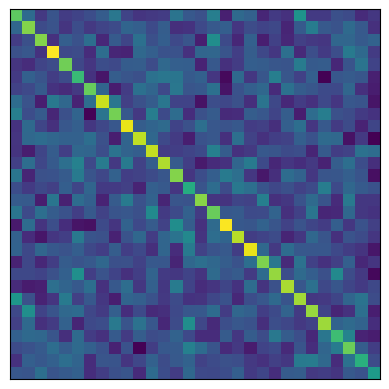

In [13]:
W = rnn_student.w_hh
plt.imshow(W.cpu().detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

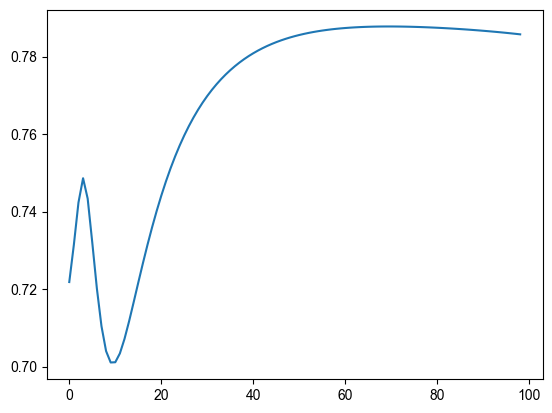

In [14]:
_=plt.plot(tbrnn_student(input[:,1:,:],hidden)[0][IDX,:,0].cpu().detach().clone().numpy())

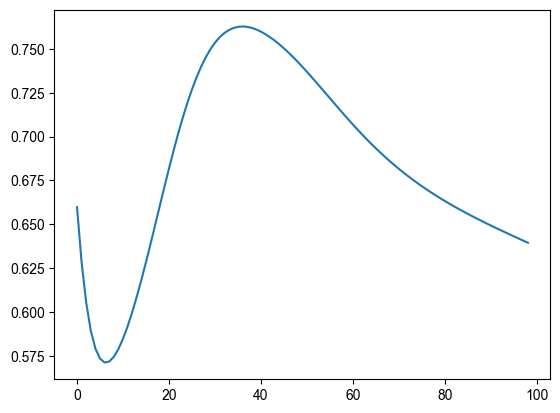

In [15]:
_=plt.plot(rnn_student(input[:,1:,:],hidden)[0][IDX,:,0].cpu().detach().clone().numpy())

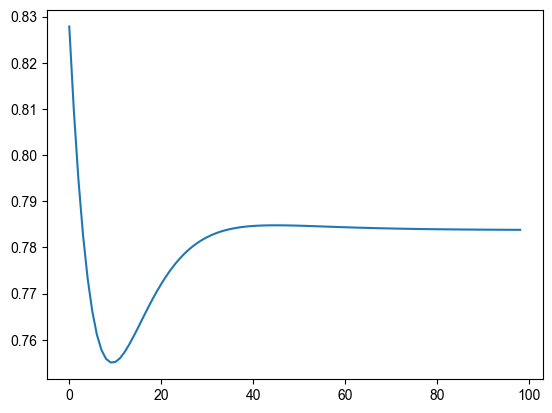

In [16]:
_=plt.plot(x_half[IDX,1:,0].cpu().numpy())